# BYOL

In this notebook we are going to implement [BYOL: Bootstrap Your Own Latent](https://arxiv.org/pdf/2006.07733.pdf) and compare the results of a classification task before and after pretraining the model with BYOL.

### Data Augmentations

In [23]:
%pip install kornia

import random
from typing import Callable, Tuple
import torch
import torchvision
from torch import nn, Tensor
from torchvision import transforms as T
from torch.nn import functional as F

from kornia import augmentation as aug
from kornia import filters
from kornia.geometry import transform as tf
import torch
from torch import nn, Tensor


class RandomApply(nn.Module):
    def __init__(self, fn: Callable, p: float):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        if random.random() > self.p:
            return x
        return self.fn(x)


def default_augmentation(image_size: Tuple[int, int] = (224, 224)) -> nn.Module:
    """
        1. resize images to 'image_size'
        2. RandomApply color jitter
        3. RandomApply grayscale
        4. RandomApply horizon flip
        5. RandomApply gaussian blur with kernel_size(3, 3), sigma=(1.5, 1.5)
        6. RandomApply ResizedCrop to 'image_size'
        7. Normalize
        choosing hyperparameters that are not mentioned is up to you
    """
    return nn.Sequential(
        tf.Resize(size=image_size),
        RandomApply(aug.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
        aug.RandomGrayscale(p=0.2),
        aug.RandomHorizontalFlip(),
        RandomApply(filters.GaussianBlur2d((3, 3), (1.5, 1.5)), p=0.1),
        aug.RandomResizedCrop(size=image_size),
        aug.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        ),
    )

# Model
We will use ResNet18 as our representation model.

In [2]:
def get_encoder_model():
    resnet = torchvision.models.resnet18()
    # remove last fully-connected layer
    # your code
    resnet.fc = nn.Linear(512, 10)
    return resnet

get_encoder_model()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss Function
We need to use NormalizedMSELoss as our loss function.
$$NormalizedMSELoss(v_1, v_2) = \Vert \bar{v_1} - \bar{v_2}\Vert_2^2 = 2 - 2.\frac{\langle v_1, v_2 \rangle}{\Vert v_1\Vert_2 \Vert v_2\Vert_2}$$

In [3]:
class NormalizedMSELoss(nn.Module):
    def __init__(self) -> None:
        super(NormalizedMSELoss,self).__init__()

    def forward(self, view1: Tensor, view2: Tensor) -> Tensor:
        view1 = F.normalize(view1, dim=-1)
        view2 = F.normalize(view2, dim=-1)
        return 2 - 2 * (view1 * view2).sum(dim=-1)

### MLP
Here you will implement a simple MLP class with one hidden layer with BatchNorm and ReLU activation, and a linear output layer. This class will be used for both the projections and the prediction networks.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, projection_dim: int = 256, hidden_dim: int = 4096) -> None:
        super(MLP,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_dim),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)

### Encoder + Projector Network
This is the network structure that is shared between online and target networks. It consists of our encoder model, followed by a projection MLP.

In [14]:
class EncoderProjecter(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 hidden_dim: int = 4096,
                 projection_out_dim: int = 256
                 ) -> None:
        super(EncoderProjecter, self).__init__()

        # your code
        self.encoder = encoder
        self.projector = MLP(10, projection_out_dim, hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.projector(x)
        return x

## BYOL

In [25]:
import torch.nn.functional as f
from copy import deepcopy
from tqdm import tqdm

class BYOL(nn.Module):
    def __init__(self,
                 model,
                 augmentation,
                 augmentation_prime,
                 encoder_out_shape = 1000,
                 projection_size = 256,
                 tau = 0.999):
        super().__init__()
        print('check')
        self.encoder_online = model
        self.projector_online = BYOL.mlp(encoder_out_shape, projection_size) # Create a network for projection
        self.online_common = nn.Sequential(self.encoder_online,
                                           self.projector_online)  # Encoder and projector are the same for target and online network

        self.predictor_online = BYOL.mlp(projection_size, projection_size)
        self.online = nn.Sequential(self.online_common, self.predictor_online) # Whole online network

        self.target = deepcopy(self.online_common) # Target network without prediction head

        self.tau = tau # Tau for moving exponential average
        self.augmentation = augmentation
        self.augmentation_prime = augmentation_prime

        self.loss_fn = nn.MSELoss(reduction="sum") # Loss function for comparision of outputs of two networks
        self.optimiser = optim.AdamW(self.online.parameters()) # Optimizer, diffrent than in paper

    @staticmethod
    def mlp(dim_in: int,
            projection_size: int,
            hidden_size: int = 4096
            ) -> nn.Module:
        return nn.Sequential(
                nn.Linear(dim_in, hidden_size), # a linear layer with output size 4096
                nn.BatchNorm1d(hidden_size), # followed by batch normalization,
                nn.ReLU(inplace=True), # rectified linear units (ReLU),
                nn.Linear(hidden_size, projection_size)) # and a final linear layer with output dimension 256

    def fit(self,
            train_dl: DataLoader,
            val_dl: DataLoader,
            epochs: int
        ) -> dict:
        results = {"train_loss": [], "val_loss": []}

        for epoch in range(epochs):
            self.train_one_epoch(train_dl) # Train (fit) model on unlabelled data

            train_loss = self.validate(train_dl) # Validate on unlabelled train data
            val_loss = self.validate(val_dl) # Validate on validation data (labels omitted)

            # Print results
            print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, validation "
                f"loss = {val_loss:.4f}, time ")
            results["train_loss"].append(float(train_loss))
            results["val_loss"].append(float(val_loss))

        return results

    def train_one_epoch(self,
                        train_dl: DataLoader
        ):
        self.online.train()
        self.target.train()

        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            loss = self.forward(X_batch)

            loss.backward()
            self.optimiser.step()
            self.optimiser.zero_grad()

            self.update_target()

        self.target.eval()
        self.online.eval()


    def forward(self,
                X_batch: torch.Tensor
        ) -> torch.Tensor:
        with torch.no_grad():
            v, v_prime = self.augmentation(X_batch), self.augmentation_prime(X_batch)

        pred1, pred2 = self.online(v), self.online(v_prime)
        pred1, pred2 = f.normalize(pred1), f.normalize(pred2)
        with torch.no_grad():
            z1, z2 = self.target(v_prime), self.target(v)
            z1, z2 = f.normalize(z1), f.normalize(z2)

        return self.loss_fn(pred1, z1) + self.loss_fn(pred2, z2)


    def update_target(self):
        for p_online, p_target in zip(self.online_common.parameters(),
                                      self.target.parameters()):
            p_target.data = self.tau * p_target.data + (1 - self.tau) * p_online.data


    def validate(self,
                 dataloader: DataLoader
        ) -> torch.Tensor:
        loss = 0
        all = 0
        for X_batch, y_batch in tqdm(dataloader):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            with torch.no_grad():
                loss += self.forward(X_batch)
            all += len(X_batch)
        return loss / all


# STL10 Datasets

We need 3 separate datasets from STL10 for this experiment:
1. `"train"` -- Contains only labeled training images. Used for supervised training.
2. `"train+unlabeled"` -- Contains training images, plus a large number of unlabelled images.  Used for self-supervised learning with BYOL.
3. `"test"` -- Labeled test images.  We use it both as a validation set, and for computing the final model accuracy.

In [7]:
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor


TRAIN_DATASET = STL10(root="data", split="train", download=True, transform=ToTensor())
TRAIN_UNLABELED_DATASET = STL10(root="data", split="train+unlabeled", download=True, transform=ToTensor())
TEST_DATASET = STL10(root="data", split="test", download=True, transform=ToTensor())

100%|██████████| 2640397119/2640397119 [02:39<00:00, 16594327.90it/s]


Extracting data/stl10_binary.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


Create dataloaders:

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    TRAIN_DATASET,
    batch_size=128,
    shuffle=True,
    drop_last=True,
)
val_loader = DataLoader(
    TEST_DATASET,
    batch_size=128,
)


# Supervised Training without BYOL

First create a classifier model by simply adding a linear layer on top of the encoder model. Then train the model using the labeled training set. Performance should be pretty good already.

In [9]:
encoder = get_encoder_model()
# your code
classifier = encoder

In [10]:
def accuracy(pred: Tensor, labels: Tensor) -> float:
    return (pred.argmax(dim=-1) == labels).float().mean().item()

In [32]:
import torch.optim as optim

class SupervisedModel():
    def __init__(self, encoder):
        self.model = encoder.cuda()

    @staticmethod
    def count_correct(
        y_pred: torch.Tensor,
        y_true: torch.Tensor
    ) -> torch.Tensor:
        preds = torch.argmax(y_pred, dim=1)
        return (preds == y_true).float().sum()


    def validate_model(
        self,
        loss_fn,
        dataloader: DataLoader
    ):

        loss = 0
        correct = 0
        all = 0
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                y_pred = self.model(X_batch)
                all += len(y_pred)
                loss += loss_fn(y_pred, y_batch)
                correct += SupervisedModel.count_correct(y_pred, y_batch)
        return loss / all, correct / all


    def train_model(
        self,
        optimiser: optim.Optimizer,
        loss_fn,
        train_dl: DataLoader,
    ):

        self.model.train()

        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            y_pred = self.model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        self.model.eval()


    def fit(
        self,
        loss_fn,
        train_dl: DataLoader,
        val_dl: DataLoader,
        epochs=50
    ) -> dict:
        results = {"train_loss": [], "train_acc": [], "val_loss": [],
                   "val_acc": []}
        optimiser = optim.AdamW(self.model.parameters())

        for epoch in range(epochs):

            self.train_model(optimiser, loss_fn, train_dl)
            train_loss, train_acc = self.validate_model(loss_fn, train_dl)
            val_loss, val_acc = self.validate_model(loss_fn, val_dl)

            print(f"Epoch {epoch + 1}: train loss = {train_loss:.3f} "
             f"(acc: {train_acc:.3f}), validation loss = {val_loss:.3f} ")
            results["train_loss"].append(float(train_loss))
            results["train_acc"].append(float(train_acc))
            results["val_loss"].append(float(val_loss))
            results["val_acc"].append(float(val_acc))

        return results

def evaluate_baseline():
    encoder = torchvision.models.resnet18()
    encoder.fc = nn.Linear(512, 10) # Resnet18 is created for 1000 classses so we need to change the last layer
    baseline_model = SupervisedModel(encoder)

    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    return baseline_model.fit(loss_fn, train_loader, val_loader)

history_baseline = evaluate_baseline()

Epoch 1: train loss = 1.932 (acc: 0.299), validation loss = 1.977 
Epoch 2: train loss = 1.365 (acc: 0.490), validation loss = 1.566 
Epoch 3: train loss = 1.293 (acc: 0.535), validation loss = 1.643 
Epoch 4: train loss = 1.268 (acc: 0.558), validation loss = 1.883 
Epoch 5: train loss = 0.982 (acc: 0.669), validation loss = 1.797 
Epoch 6: train loss = 0.535 (acc: 0.820), validation loss = 1.841 
Epoch 7: train loss = 0.360 (acc: 0.874), validation loss = 1.833 
Epoch 8: train loss = 0.321 (acc: 0.890), validation loss = 2.082 
Epoch 9: train loss = 0.202 (acc: 0.927), validation loss = 1.952 
Epoch 10: train loss = 0.091 (acc: 0.968), validation loss = 2.081 
Epoch 11: train loss = 0.057 (acc: 0.982), validation loss = 1.979 
Epoch 12: train loss = 0.029 (acc: 0.991), validation loss = 1.962 
Epoch 13: train loss = 0.084 (acc: 0.972), validation loss = 2.160 
Epoch 14: train loss = 0.211 (acc: 0.933), validation loss = 2.308 
Epoch 15: train loss = 0.109 (acc: 0.965), validation los

### Self-Supervised Training with BYOL

Now perform the self-supervised training. This is the most computationally intensive part of the script.

In [33]:
encoder = torchvision.models.resnet18()
encoder.fc = nn.Identity()
model = BYOL(encoder, default_augmentation(), default_augmentation(), encoder_out_shape = 512).cuda()
history = model.fit(train_loader, val_loader, 10)

check


100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch 1: train loss = 1.7648, validation loss = 1.7680, time 


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Epoch 2: train loss = 1.7504, validation loss = 1.7611, time 


100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch 3: train loss = 1.6639, validation loss = 1.6403, time 


100%|██████████| 63/63 [00:33<00:00,  1.88it/s]


Epoch 4: train loss = 1.5160, validation loss = 1.5242, time 


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Epoch 5: train loss = 1.3234, validation loss = 1.3404, time 


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Epoch 6: train loss = 1.3026, validation loss = 1.2831, time 


100%|██████████| 63/63 [00:33<00:00,  1.88it/s]


Epoch 7: train loss = 1.2375, validation loss = 1.2500, time 


100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch 8: train loss = 1.2193, validation loss = 1.2212, time 


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Epoch 9: train loss = 1.2374, validation loss = 1.2580, time 


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]

Epoch 10: train loss = 1.2357, validation loss = 1.2175, time 


In [28]:
del classifier



### Supervised Training Again

Extract the encoder network's state dictionary from BYOL, and load it into our ResNet18 model before starting training.  Then run supervised training, and watch the accuracy improve from last time!

Epoch 1: train loss = 1.620 (acc: 0.390), validation loss = 1.654 
Epoch 2: train loss = 1.657 (acc: 0.381), validation loss = 1.690 
Epoch 3: train loss = 1.740 (acc: 0.423), validation loss = 1.848 
Epoch 4: train loss = 1.260 (acc: 0.532), validation loss = 1.403 
Epoch 5: train loss = 1.201 (acc: 0.559), validation loss = 1.406 
Epoch 6: train loss = 1.028 (acc: 0.620), validation loss = 1.350 
Epoch 7: train loss = 0.945 (acc: 0.659), validation loss = 1.396 
Epoch 8: train loss = 0.636 (acc: 0.771), validation loss = 1.337 
Epoch 9: train loss = 0.688 (acc: 0.767), validation loss = 1.688 
Epoch 10: train loss = 0.323 (acc: 0.889), validation loss = 1.486 
Epoch 11: train loss = 0.290 (acc: 0.901), validation loss = 1.638 
Epoch 12: train loss = 0.304 (acc: 0.892), validation loss = 1.876 
Epoch 13: train loss = 0.609 (acc: 0.817), validation loss = 2.650 
Epoch 14: train loss = 0.230 (acc: 0.920), validation loss = 2.037 
Epoch 15: train loss = 0.068 (acc: 0.980), validation los

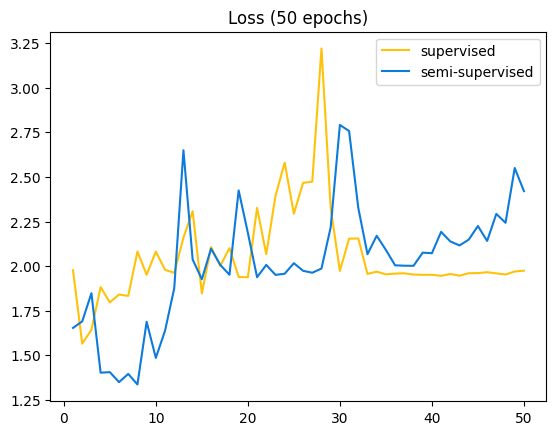

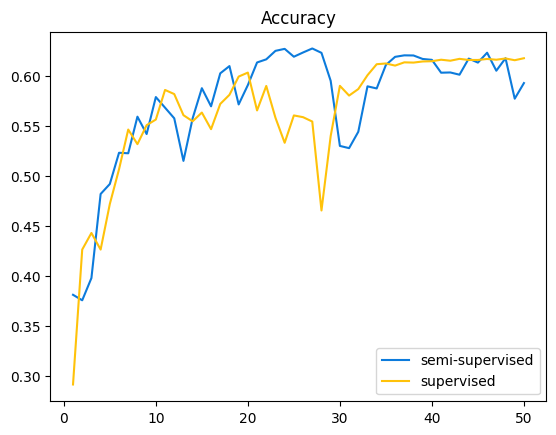

In [34]:
state_dict = model.encoder_online.state_dict()
encoder_post = torchvision.models.resnet18()
encoder_post.fc = nn.Identity()
encoder_post.load_state_dict(state_dict)
# for param in encoder_post.parameters():
#     param.requires_grad = False

encoder_post.fc = nn.Linear(512, 10)

semi_sup_model = SupervisedModel(encoder_post)
loss_fn = nn.CrossEntropyLoss(reduction='sum')
history = semi_sup_model.fit(loss_fn, train_loader, val_loader)

import matplotlib.pyplot as plt

epochs_x = list(range(1, 51))

plt.plot(epochs_x, history_baseline["val_loss"], "#FFC20A", label="supervised")
plt.plot(epochs_x, history["val_loss"], "#0C7BDC", label="semi-supervised")
plt.title("Loss (50 epochs)")
plt.legend()
plt.show()

plt.plot(epochs_x, history["val_acc"], "#0C7BDC", label="semi-supervised")
plt.plot(epochs_x, history_baseline["val_acc"], "#FFC20A", label="supervised")
plt.title("Accuracy")
plt.legend()
plt.show()